['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


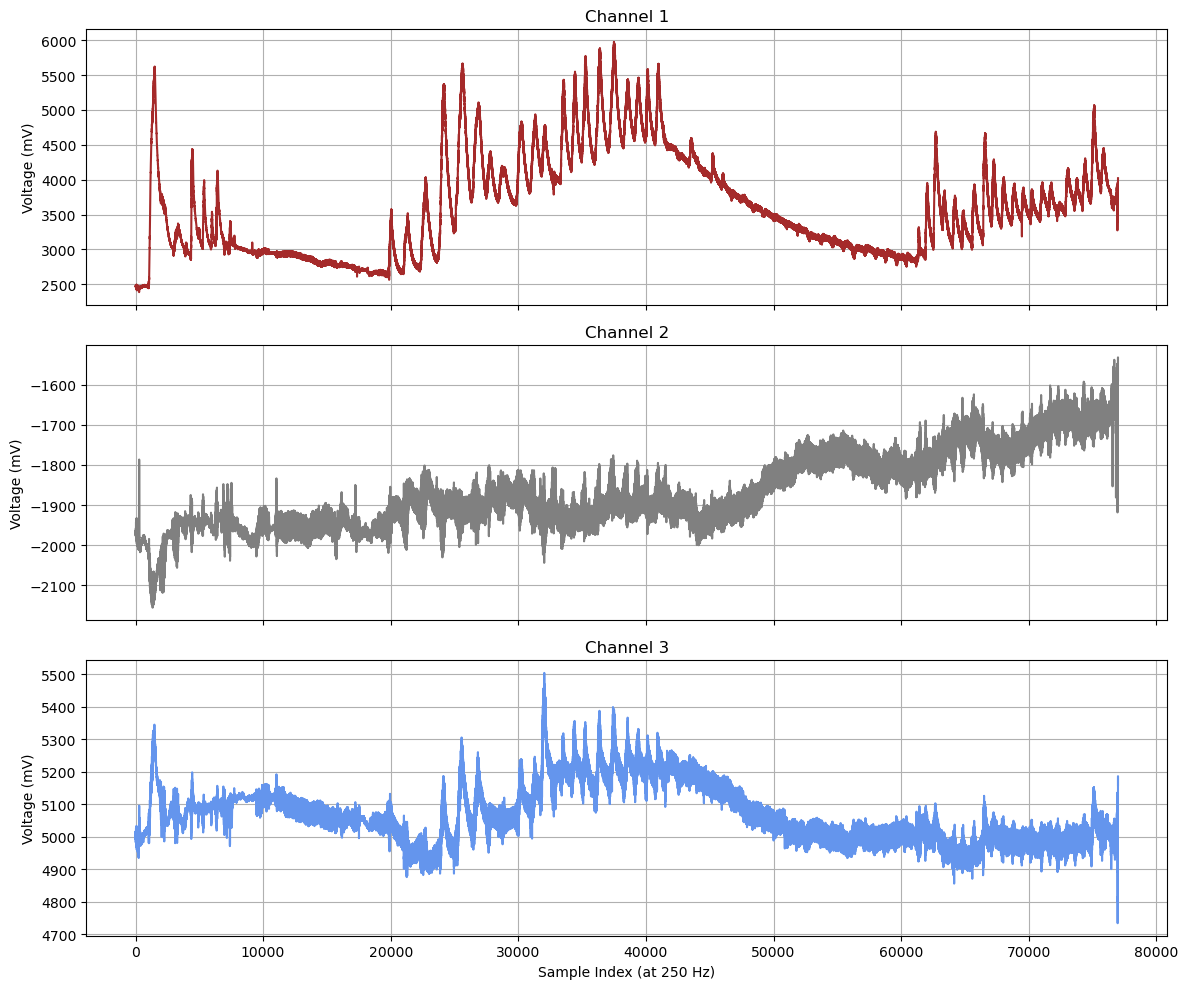

In [1]:
# -------------------------- Visualization of Raw data

import pandas as pd
import matplotlib.pyplot as plt

# Load OpenBCI data
path = "C:/Quick_Disk/tonge_emg_xr_project/data/Recordings4/recording4.csv"
df = pd.read_csv(path, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df.columns = [f"ch_{i}" for i in range(df.shape[1])]
print(df.columns.tolist())

# Define sampling rate and duration
sampling_rate = 250  # Hz
num_samples = df.shape[0] # sampling_rate * duration_sec  # 5000 samples

# Create subplots
channel_colors = {
    'ch_1': 'brown',
    'ch_2': 'gray',
    'ch_3': '#6495ed'
}
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Channel 1
axs[0].plot(df.iloc[:num_samples, 1], color=channel_colors['ch_1'])
axs[0].set_title("Channel 1")
axs[0].set_ylabel("Voltage (mV)")
axs[0].grid(True)

# Plot Channel 2
axs[1].plot(df.iloc[:num_samples, 2], color=channel_colors['ch_2'])
axs[1].set_title("Channel 2")
axs[1].set_ylabel("Voltage (mV)")
axs[1].grid(True)

# Plot Channel 3
axs[2].plot(df.iloc[:num_samples, 3], color=channel_colors['ch_3'])
axs[2].set_title("Channel 3")
axs[2].set_xlabel("Sample Index (at 250 Hz)")
axs[2].set_ylabel("Voltage (mV)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


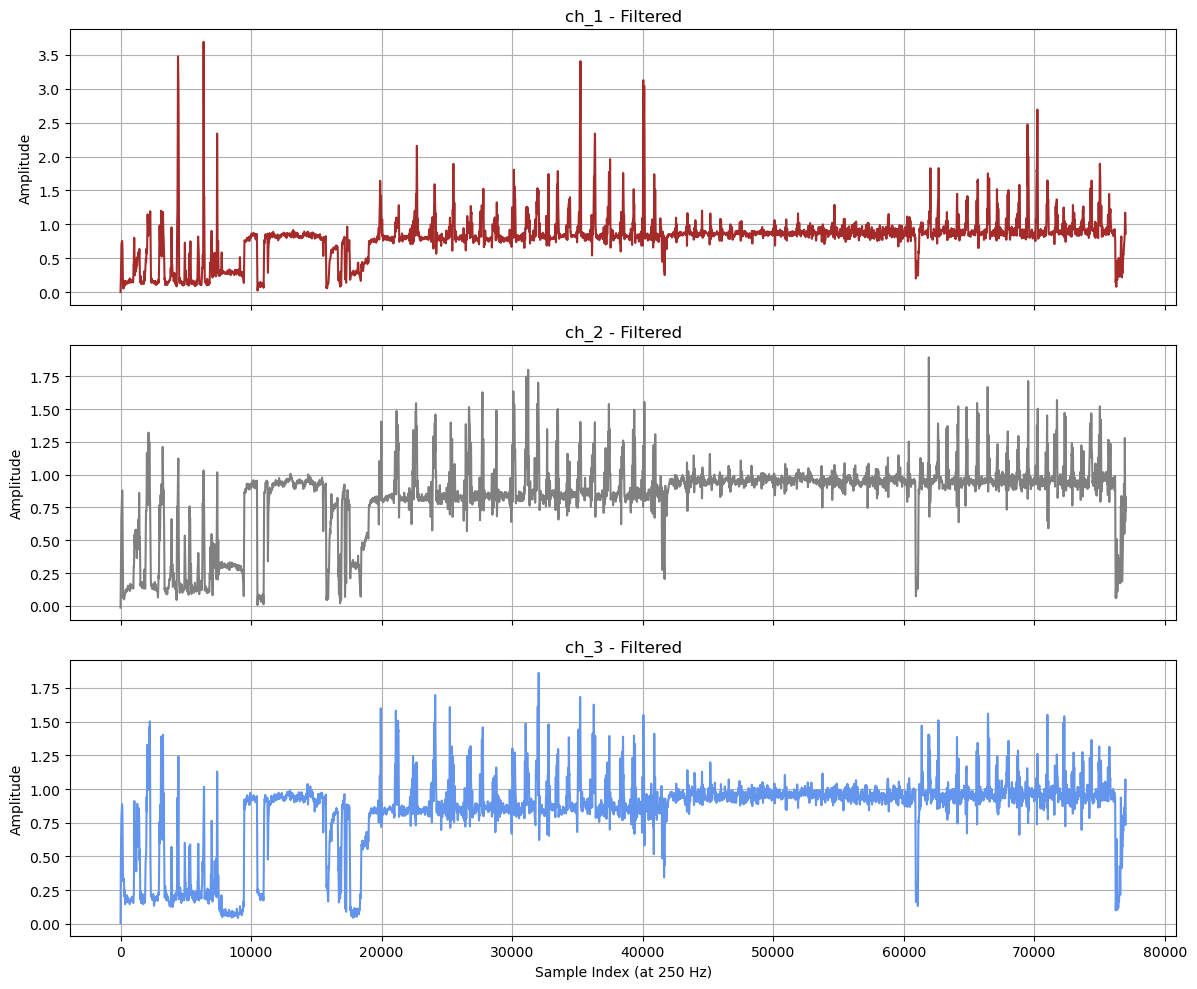

In [4]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt
import numpy as np

lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff=5.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# Bandpass and Z-score
filtered = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    # Bandpass
    raw_filtered = bandpass_filter(df[ch][:num_samples])
    
    # Z-score normalization
    mean = np.mean(raw_filtered)
    std = np.std(raw_filtered)
    zscored = (raw_filtered - mean) / std
    
    # Full-wave rectification
    rectified = np.abs(zscored)
    # Smoothing (low-pass filter)
    smoothed = lowpass_filter(rectified)
    filtered[ch] = smoothed

# Plot filtered signals
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3']):
    axs[i].plot(filtered[ch], label=f"{ch} (filtered)", color=channel_colors[ch])
    axs[i].set_title(f"{ch} - Filtered")
    axs[i].set_ylabel("Amplitude")
    axs[i].grid(True)

axs[2].set_xlabel("Sample Index (at 250 Hz)")
plt.tight_layout()
plt.show()


Annotations head
  class     timestamp
0     l  1.749033e+09
1     l  1.749033e+09
2     l  1.749033e+09
3     l  1.749033e+09
4     l  1.749033e+09

EMG head
   ch_0         ch_1         ch_2         ch_3  ch_4  ch_5  ch_6  ch_7  ch_8  \
0   6.0  2469.331320 -1972.586152  4998.565316   0.0   0.0   0.0   0.0   0.0   
1   7.0  2470.784184 -1976.654169  4993.245601   0.0   0.0   0.0   0.0   0.0   
2   8.0  2473.958132 -1972.250876  5003.460348   0.0   0.0   0.0   0.0   0.0   
3   9.0  2471.477088 -1967.333492  5014.949145   0.0   0.0   0.0   0.0   0.0   
4  10.0  2469.510134 -1970.507439  5012.132825   0.0   0.0   0.0   0.0   0.0   

    ch_9  ...  ch_14  ch_15  ch_16  ch_17  ch_18  ch_19  ch_20  ch_21  \
0  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.016  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.018  ...  144.0  255.0  208.0  224.0   16.0    0.0    0.0    0.0   
3  0.018  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

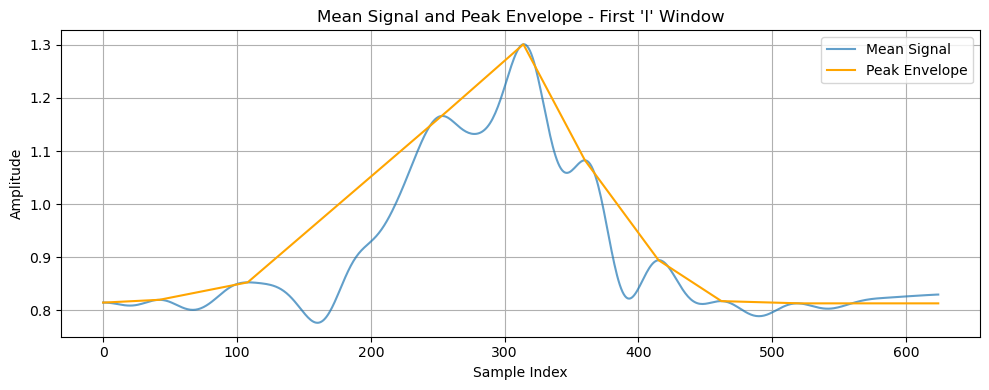

In [14]:
# -------------------------- Windowing (Peak-Based Envelope)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load annotations
annotations_path = r"C:\Quick_Disk\tonge_emg_xr_project\scripts\data\annotations\annotations4.csv"
annotations = pd.read_csv(annotations_path, header=0, names=['class', 'timestamp'])
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')

print("Annotations head")
print(annotations.head())
print("\nEMG head")
print(df.head())

# Get EMG timestamps
emg_timestamps = df['ch_22']  # Unix timestamps 

# Define window size
window_size_seconds = 2.5
windowed_data = {'l': []}

for idx, row in annotations.iterrows():
    label = row['class']      
    start_time = row['timestamp']
    end_time = start_time + window_size_seconds

    if label != 'l':
        continue
    
    idxs = (emg_timestamps >= start_time) & (emg_timestamps < end_time)
    if not any(idxs):
        print(f"No data for window starting at {start_time} (label={label})")
        continue

    window_ch1 = filtered['ch_1'][idxs]
    window_ch2 = filtered['ch_2'][idxs]
    window_ch3 = filtered['ch_3'][idxs]
    window_mean = np.mean([window_ch1, window_ch2, window_ch3], axis=0)

    # --- Compute envelope using peaks ---
    peaks, _ = find_peaks(window_mean, distance=10)  # Adjust distance as needed
    if len(peaks) < 2:  # Need at least 2 points to interpolate
        print(f"Not enough peaks to compute envelope in window starting at {start_time}")
        continue
    peak_values = window_mean[peaks]
    envelope = np.interp(np.arange(len(window_mean)), peaks, peak_values)

    # Store results
    windowed_data[label].append({
        'mean_signal': window_mean,
        'envelope': envelope,
        'start_time': start_time,
        'end_time': end_time
    })

# Summary
print("\nHow many windows per class:")
print(f"Class 'l' windows: {len(windowed_data['l'])}")

# Inspect first window
first_window = windowed_data['l'][0]
print("\nSamples in first averaged 'l' window:", len(first_window['mean_signal']))

# Plot mean and envelope for the first window
plt.figure(figsize=(10, 4))
plt.plot(first_window['mean_signal'], label='Mean Signal', alpha=0.7)
plt.plot(first_window['envelope'], label='Peak Envelope', color='orange')
plt.title("Mean Signal and Peak Envelope - First 'l' Window")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


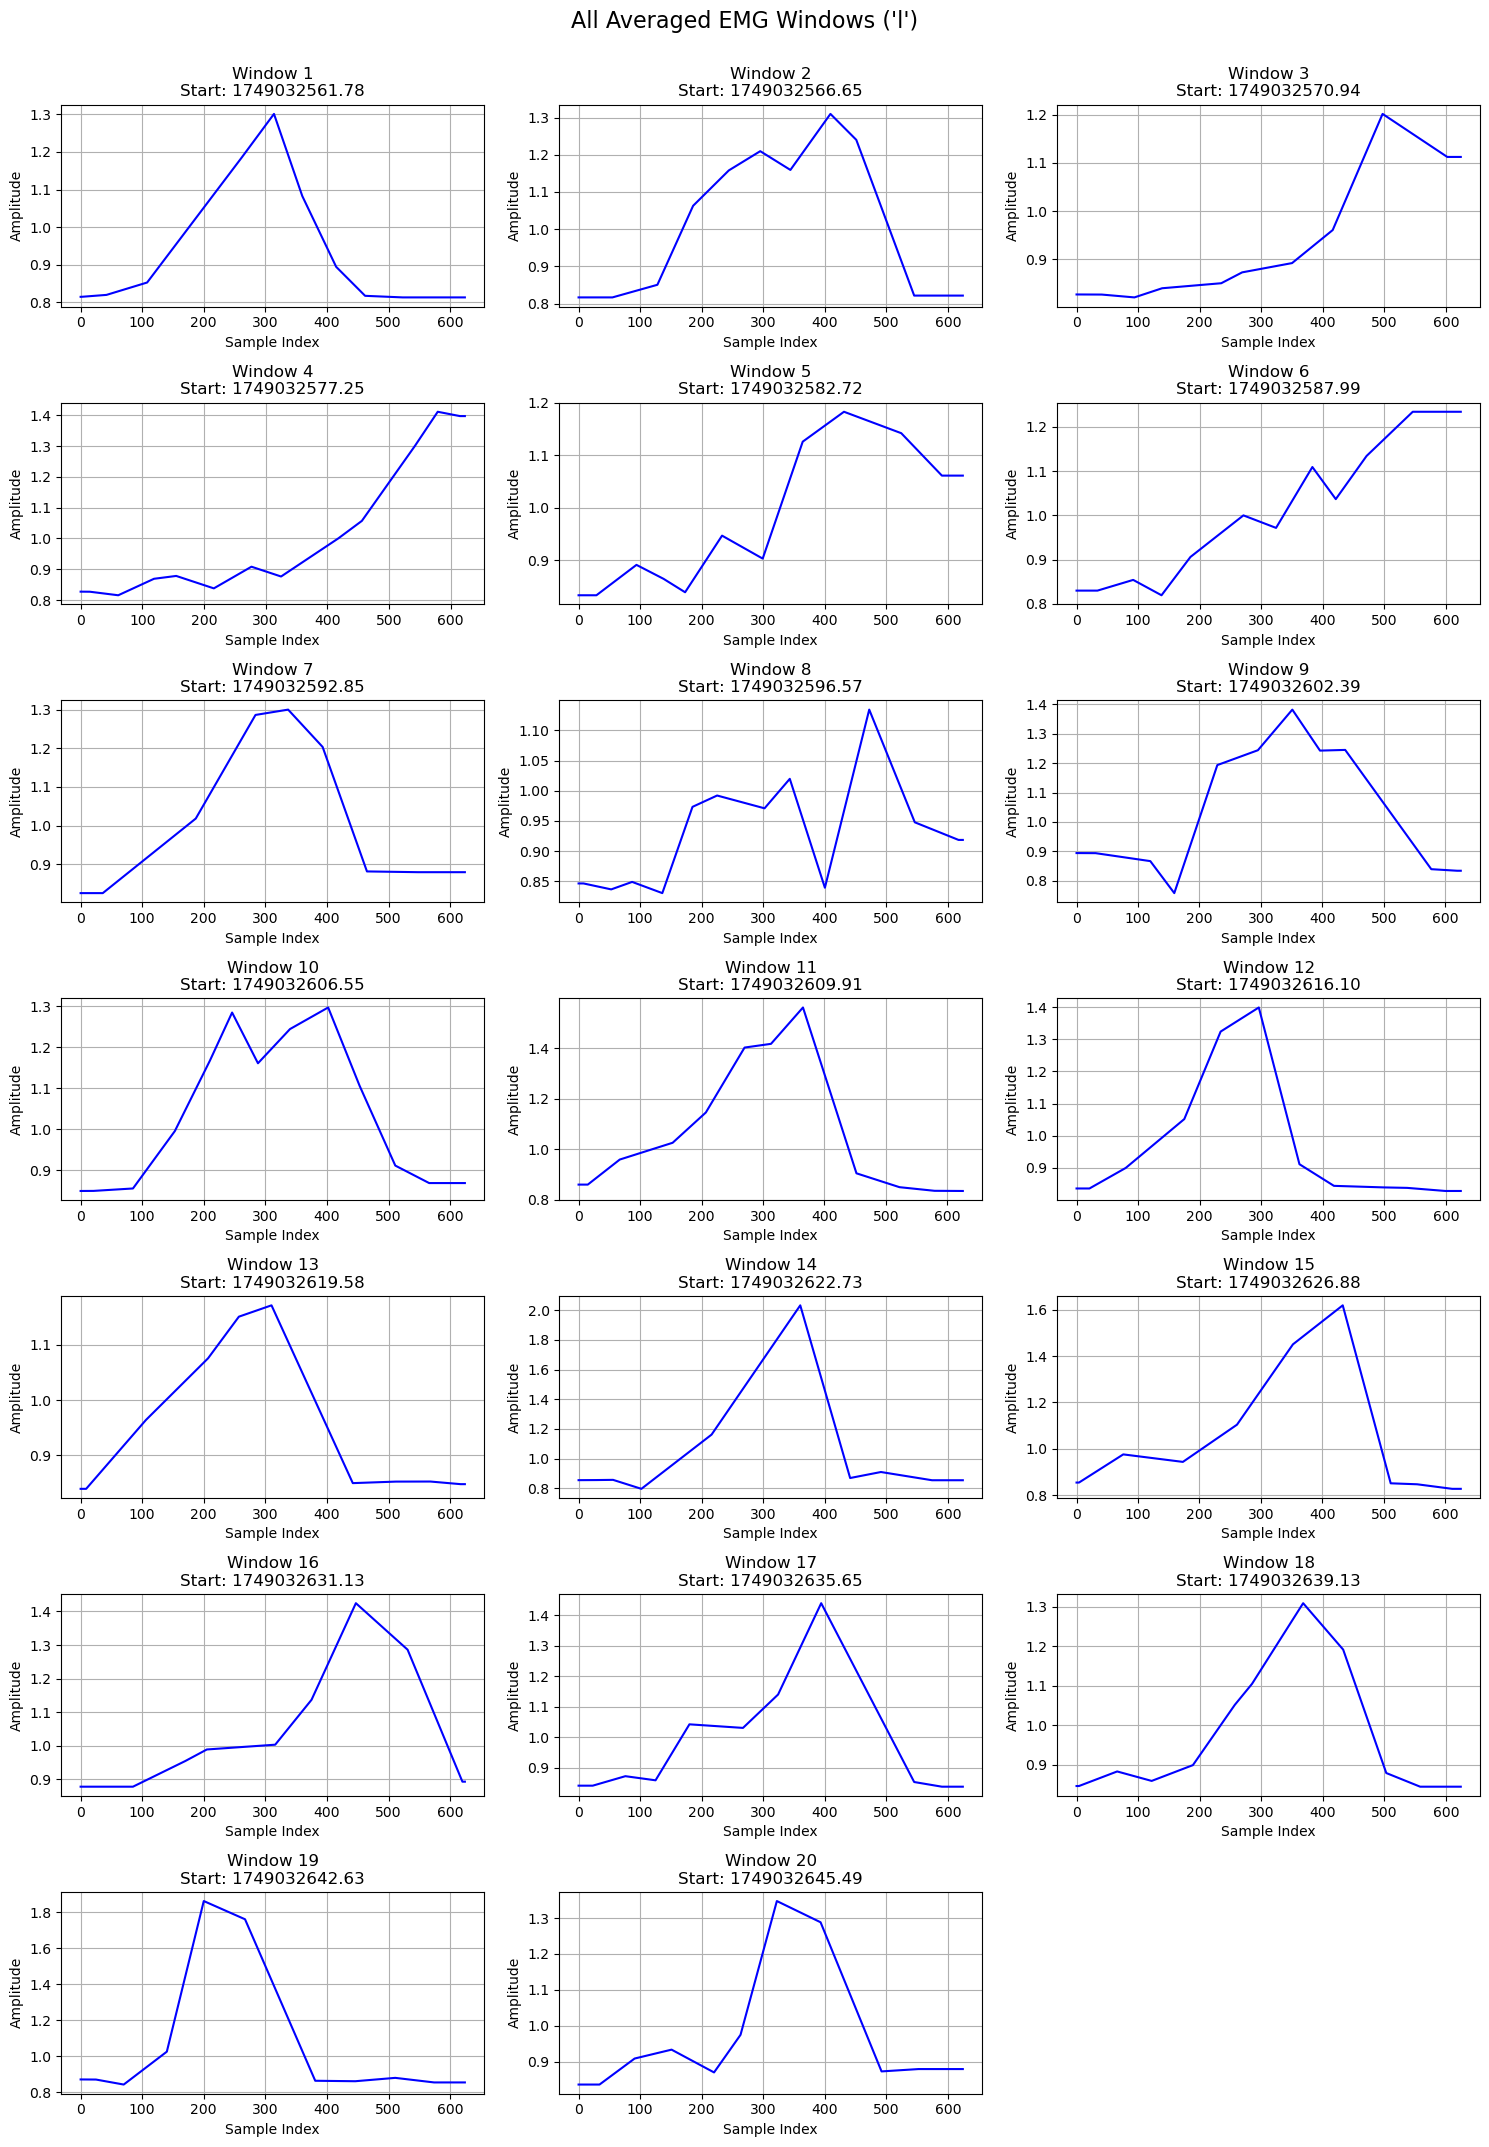

In [15]:
# ------------------------------ plot all 

import matplotlib.pyplot as plt
import math

# Get all mean signals
windows = windowed_data['l']
num_windows = len(windows)

# Configure grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_windows / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), sharex=False)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, window in enumerate(windows):
    mean_signal = window['envelope']
    axes[i].plot(mean_signal, label=f"Window {i+1}", color='blue')
    axes[i].set_title(f"Window {i+1}\nStart: {window['start_time']:.2f}")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

# Hide any extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("All Averaged EMG Windows ('l')", fontsize=16, y=1.02)
plt.show()
